In [1]:
import tensorflow as tf
import modules.layers as tf_util
import modules.utility as util
import numpy as np
import tables
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

#######################################################
# Get data
#############
#CT Dataset
# train = data_path+'train_192_ct.hdf5'
# val = data_path+'val_192_ct.hdf5'
# test = data_path+'test_192_ct.hdf5'
# MODEL_CODE = 'ct'
data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'
#MR Dataset
train = data_path+'train_192_mr.hdf5'
val = data_path+'val_192_mr.hdf5'
test = data_path+'test_192_mr.hdf5'
MODEL_CODE = 'mr'

f_train = tables.open_file(train)
f_val = tables.open_file(val)

input_shape = f_train.root.X.shape
output_shape = f_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)
print f_val.root.X.shape##########################################



Using TensorFlow backend.


<IPython.core.display.Javascript object>

autoscrolling long output is disabled
(143394, 192, 192, 1) (143394, 192, 192, 1)
data shapes, train=(143394, 192, 192, 1),(143394, 192, 192, 1)
(12812, 192, 192, 1)


In [2]:
######################################################
# Define variables
######################################################
N = f_train.root.X.shape[0]
Nval = f_val.root.X.shape[0]
W,H,C = f_train.root.X[0].shape
C=1
crop_dims = 128
Nbatch = 32
lr = 1e-5
Nsteps=40000
print_step=200
init = 6e-2

Nfilters = 32

EPS=1e-4
leaky_relu = tf.contrib.keras.layers.LeakyReLU(0.2)
y_index=0
alph = 0.3
beta = 0.7

In [3]:


def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
    return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x)-alpha)
#########################################################
# Define graph
#########################################################
x = tf.placeholder(shape=[None,crop_dims,crop_dims,C],dtype=tf.float32)
y = tf.placeholder(shape=[None,crop_dims,crop_dims,C],dtype=tf.float32)

yclass,yhat,o3,o4 = tf_util.I2INet(x,nfilters=Nfilters,activation=leaky_relu,init=init)

# TP = tf.reduce_sum(yclass*y)
# FP = tf.reduce_sum(yclass*(1-y))
# FN = tf.reduce_sum((1-yclass)*y)
# loss = -TP/(TP + alph*FP+beta*FN+EPS)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=yhat,labels=y))

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

print yclass

saver = tf.train.Saver()

Tensor("Sigmoid:0", shape=(?, 128, 128, 1), dtype=float32)


(192, 192, 1) (192, 192)


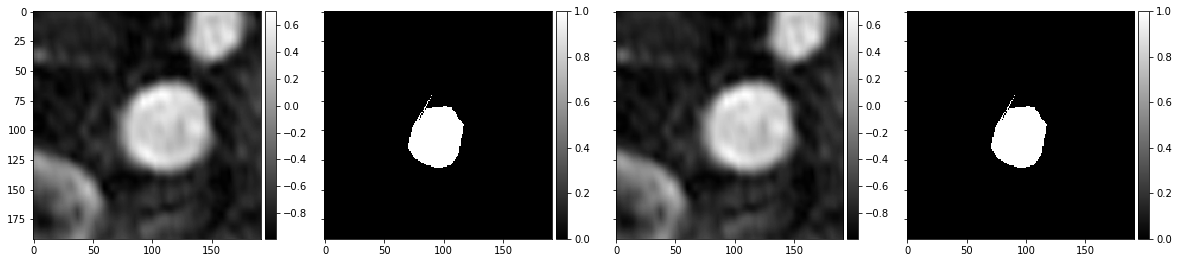

(192, 192, 1) (192, 192)


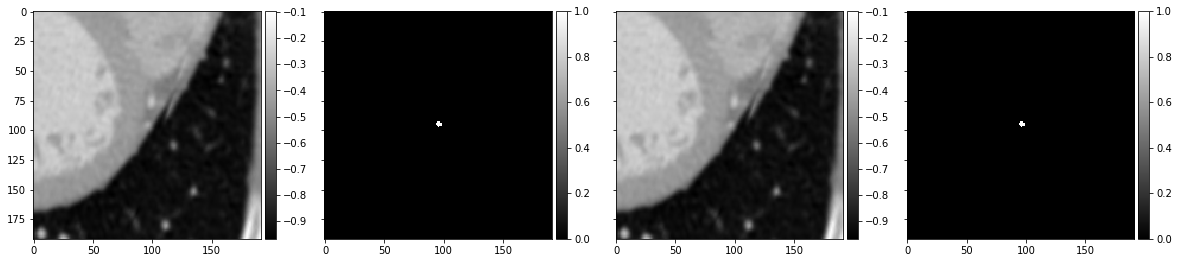

(192, 192, 1) (192, 192)


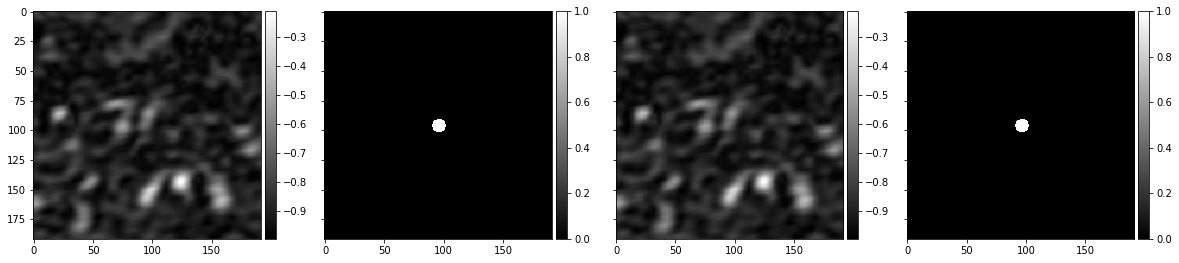

(192, 192, 1) (192, 192)


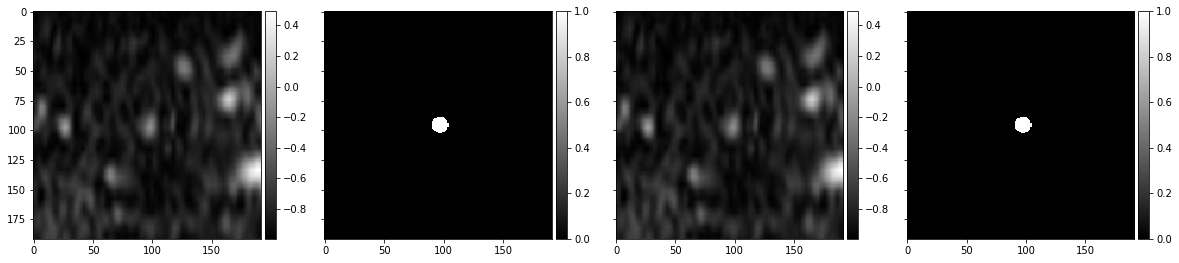

(192, 192, 1) (192, 192)


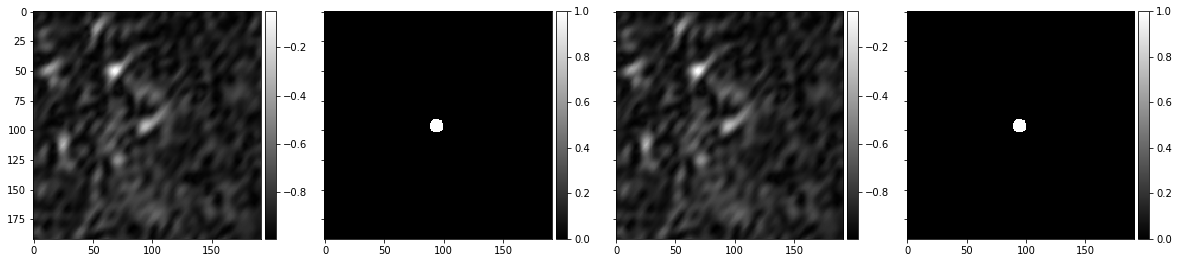

(192, 192, 1) (192, 192)


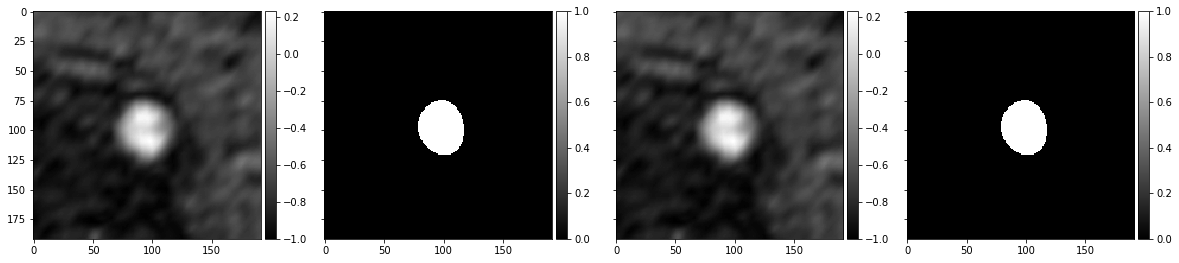

(192, 192, 1) (192, 192)


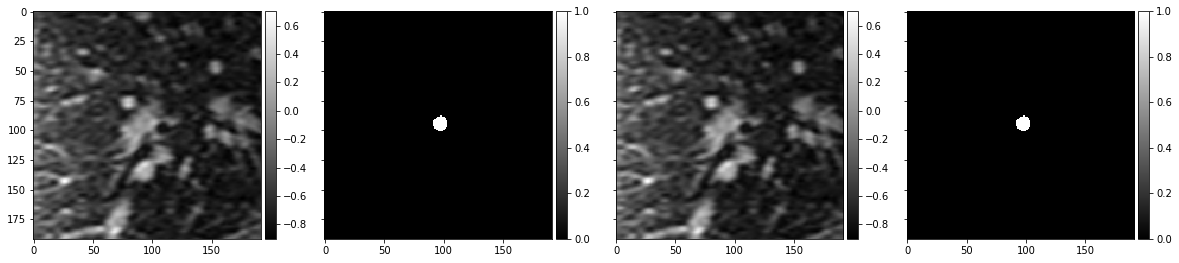

In [4]:
######################################################
# Plot
######################################################
alpha=0
sigma=0
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(7):
    j = np.random.randint(N)
    x_im = f_train.root.X[j].astype(np.float32)
    y_im = f_train.root.Y[j].astype(np.float32)
    
    trans = util.elastic_transform([x_im[:,:,0],y_im[:,:,0]],alpha,sigma)
    x_trans = trans[0]
    y_trans = trans[1]

    print x_im.shape, x_trans.shape
    plt.figure()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    implot(x_im[:,:,0],ax1)
    implot(y_im[:,:,0],ax2)
    implot(x_trans[:,:],ax3)
    implot(y_trans[:,:],ax4)
    plt.tight_layout
    plt.savefig('transform_{}.pdf'.format(j),dpi=600)
    plt.show()

In [5]:
def get_batch(X,Y,N,n=32, gen_angles=True, crop_dims=128, offset=2, noise=0.0, alpha=34, sigma=4):
    inds = np.random.choice(range(N),size=n, replace=False)
    x = X[inds,:,:,0].astype(np.float32)
    y = Y[inds,:,:,0].astype(np.float32)

    #rotations
    if gen_angles:
        angles = np.random.randint(360, size=x.shape[0])
        xrot = np.zeros(x.shape)
        yrot = np.zeros(y.shape)
    for i in range(len(angles)):
        xrot[i] = rotate(x[i],angles[i], axes=(1,0), reshape=False)
        yrot[i] = rotate(y[i],angles[i], axes=(1,0), reshape=False)
        
    #random crops
    space = offset
    starts = np.random.randint(space, size=[x.shape[0],2])*2 - space
    startsx = W/2-crop_dims/2+starts[:,0]
    startsy = H/2-crop_dims/2+starts[:,1]
    
    xret = np.zeros((n,crop_dims,crop_dims)).astype(float)
    yret = np.zeros((n,crop_dims,crop_dims)).astype(float)
    for i in range(x.shape[0]):
#         ims = [xrot[i],yrot[i]]
#         im_list = util.elastic_transform(ims,alpha,sigma)
#         xrot[i] = im_list[0]
#         yrot[i] = im_list[1]
        
        xret[i] = xrot[i,startsx[i]:startsx[i]+crop_dims,startsy[i]:startsy[i]+crop_dims]

        yret[i] = yrot[i,startsx[i]:startsx[i]+crop_dims,startsy[i]:startsy[i]+crop_dims]


        
    xret = xret[:,:,:,np.newaxis]
    yret = yret[:,:,:,np.newaxis]

    xret = xret+(2*np.random.rand()-1)*noise
    return xret,yret

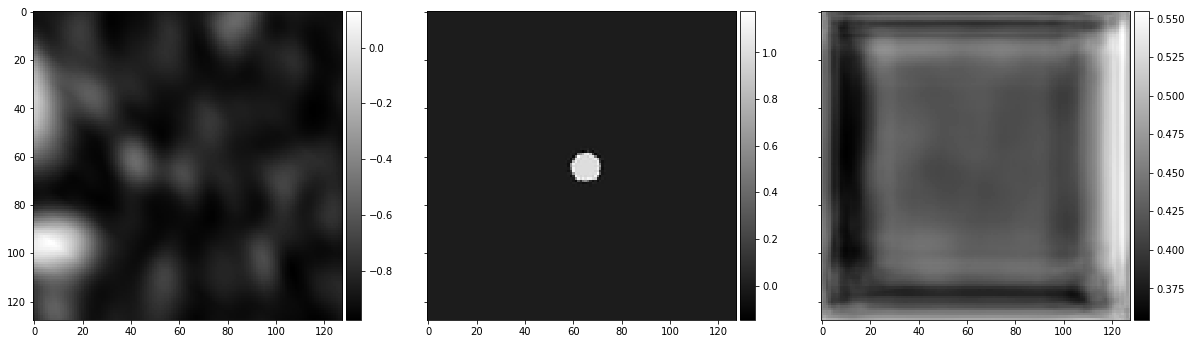

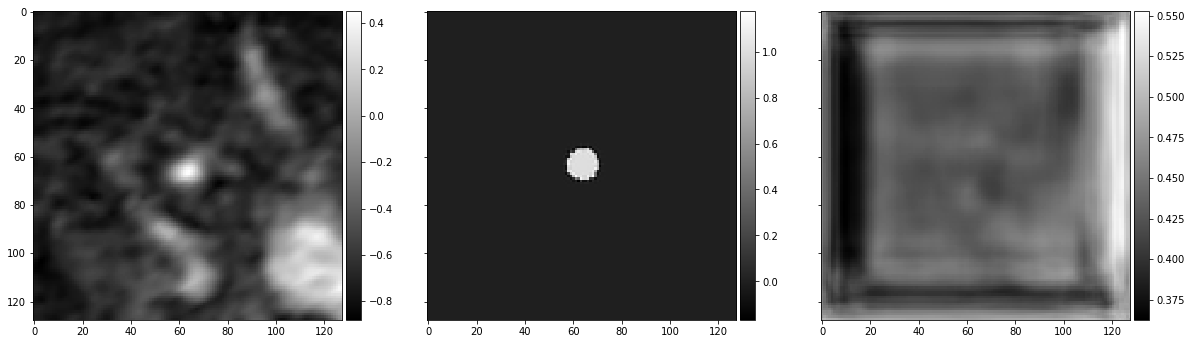

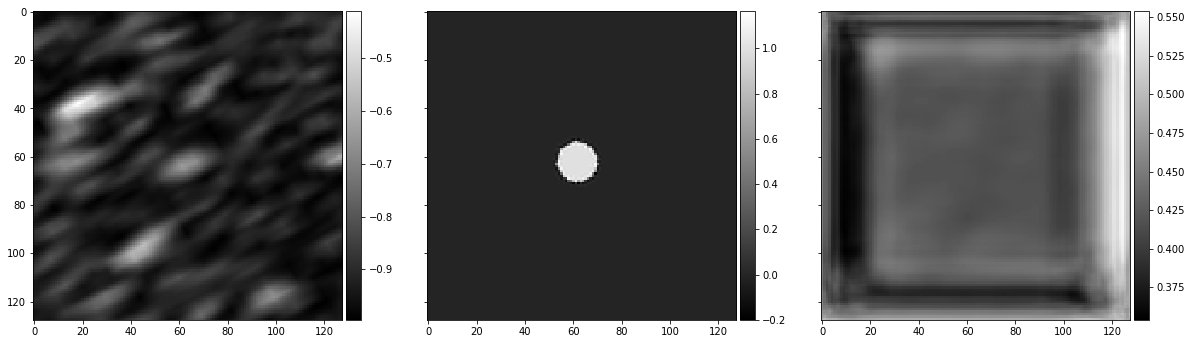

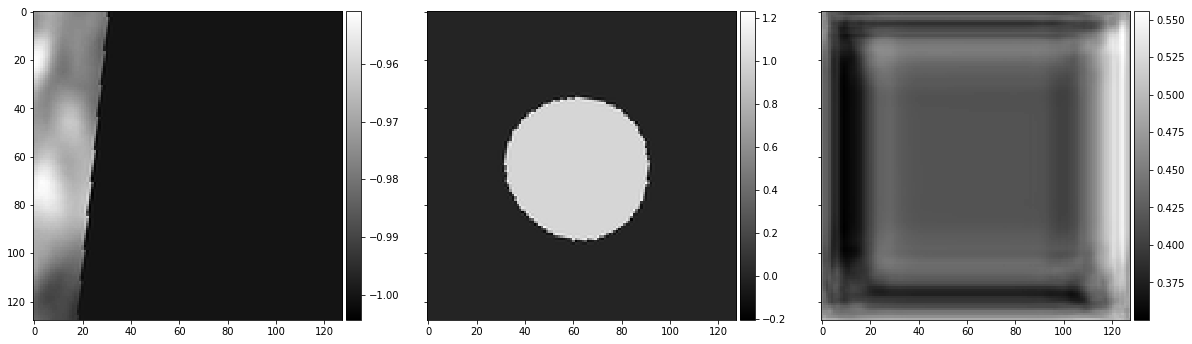

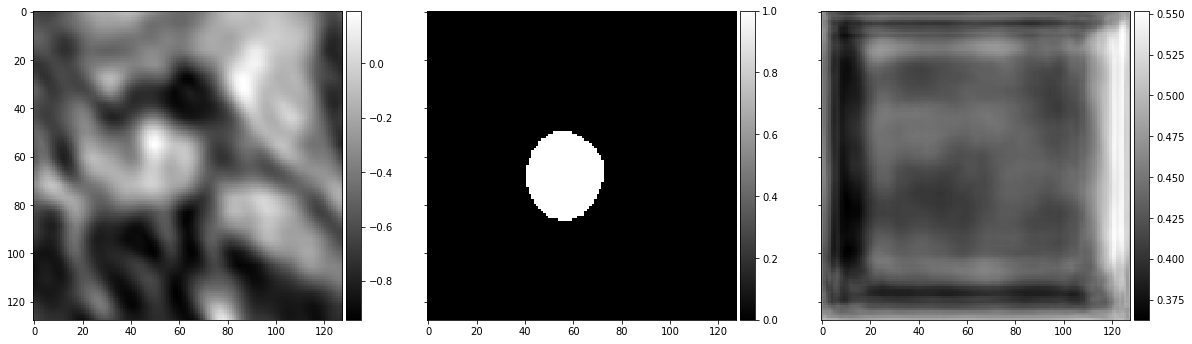

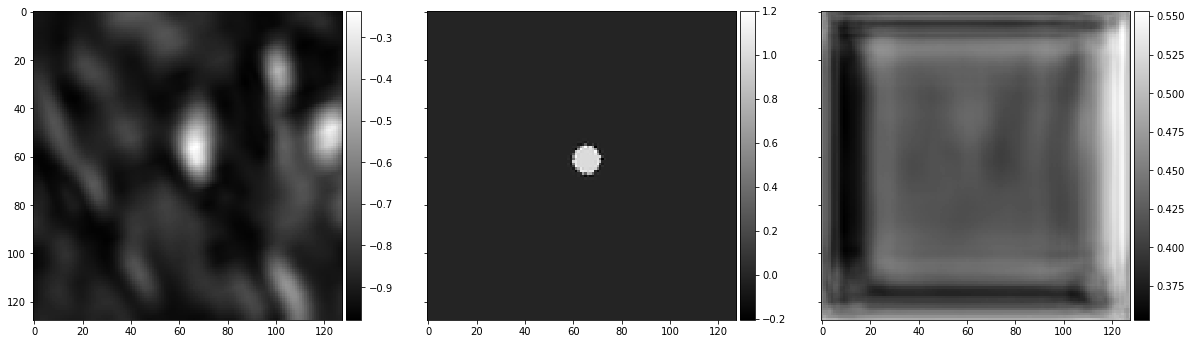

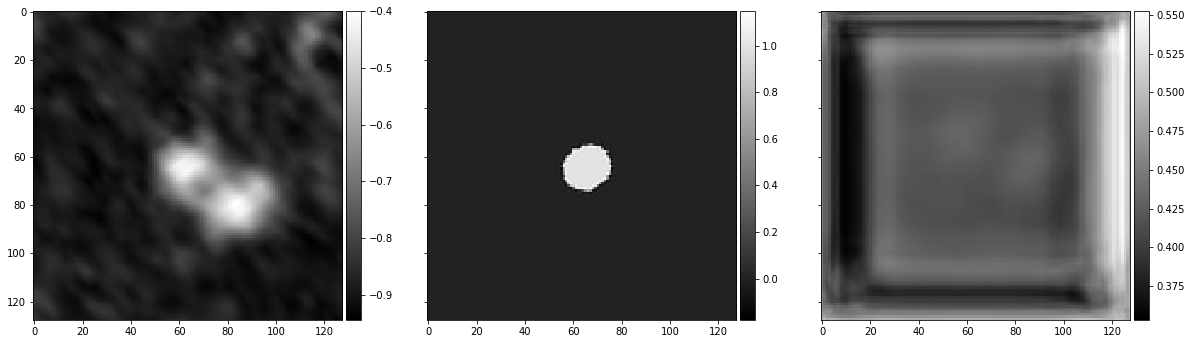

In [6]:
######################################################
# Plot
######################################################
    
xb,yb = get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,crop_dims=crop_dims,alpha=0,sigma=0)
yout =sess.run(yclass,{x:xb,y:yb})
 
for i in range(7):
    xval = xb[i:i+2]
    yval = yb[i:i+2][:,:,:,:]
    ypred = yout[i:i+2]
    
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    implot(xval[0,:,:,0],ax1)
    implot(yval[0,:,:,0],ax2)
    implot(ypred[0,:,:,0],ax3)
    plt.tight_layout
    plt.show()

In [ ]:
print xval.shape
print yval.shape
print yout.shape

(2, 128, 128, 1)
(2, 128, 128, 1)
(32, 128, 128, 1)


In [ ]:
# #######################################################
# # Train positive
# #######################################################
train_hist = []
val_hist = []

for i in range(Nsteps+1):
    xb,yb = get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,crop_dims=crop_dims)
    l,_=sess.run([loss,train],{x:xb,y:yb})
    if i%(print_step)==0:
        print "iteration {}".format(i)

        xb,yb = get_batch(f_val.root.X,f_val.root.Y,Nval,Nbatch,crop_dims=crop_dims)
        lval,ypred=sess.run([loss,yclass],{x:xb,y:yb})
        print "Train: {}, Val: {}, p var {}, p mean {}, p max {}, p min {}".format(l,lval,
                np.var(ypred),np.mean(ypred), np.amax(ypred),np.amin(ypred))

        saver.save(sess,'./models/i2i_vanilla_{}/i2i_{}'.format(MODEL_CODE,MODEL_CODE))
        
        train_hist.append(l)
        val_hist.append(lval)

iteration 0
Train: 0.566713988781, Val: 0.508998394012, p var 0.00198647053912, p mean 0.381121516228, p max 0.544061124325, p min 0.305324941874
iteration 200
Train: 0.038703750819, Val: 0.147642686963, p var 0.00151119683869, p mean 0.0140236308798, p max 0.449897408485, p min 0.000104729762825
iteration 400
Train: 0.0339034684002, Val: 0.0763916894794, p var 0.00171573716216, p mean 0.0139510873705, p max 0.527228713036, p min 0.000169002873008


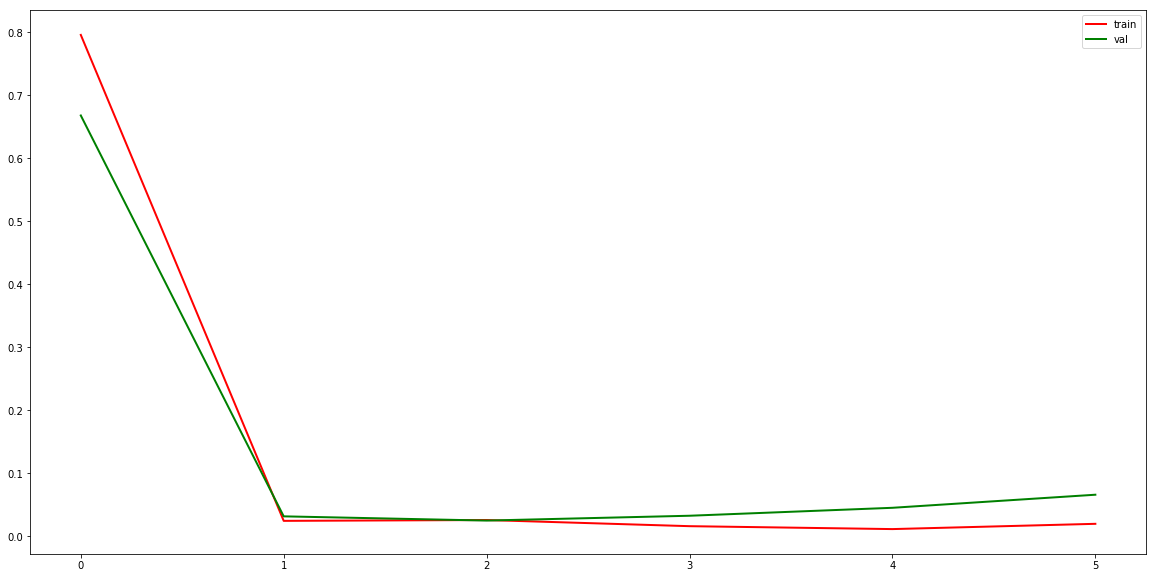

In [9]:
plt.figure()
plt.plot(train_hist, linewidth=2,color='r',label='train')
plt.plot(val_hist, linewidth=2,color='g',label='val')
plt.legend()
plt.show()

In [7]:
f_test = tables.open_file(test)

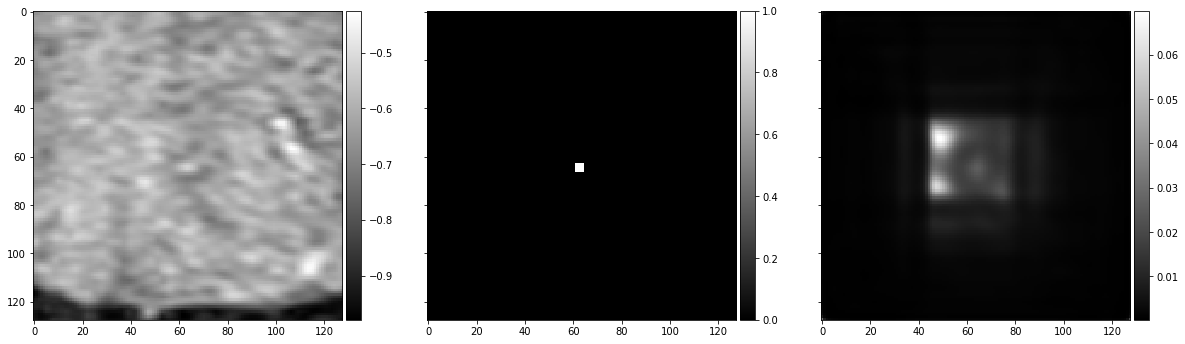

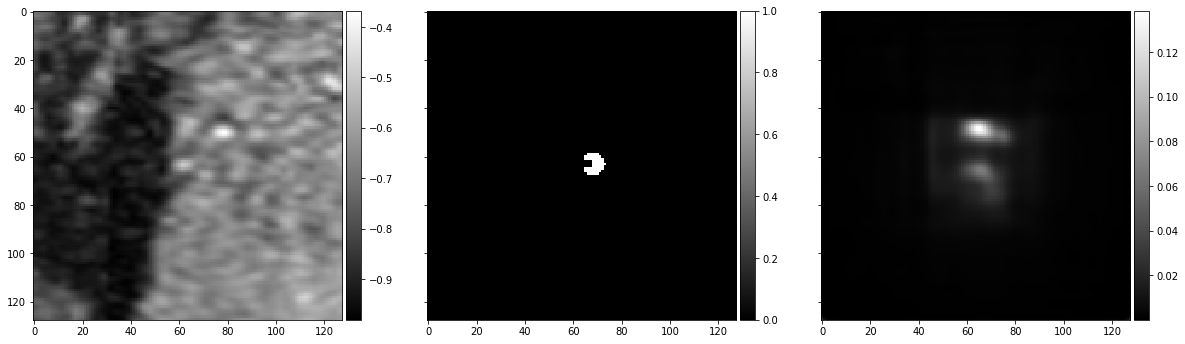

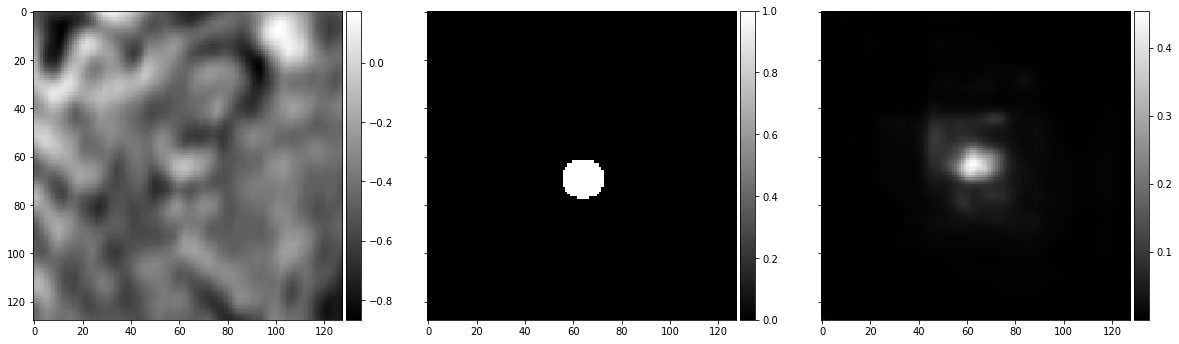

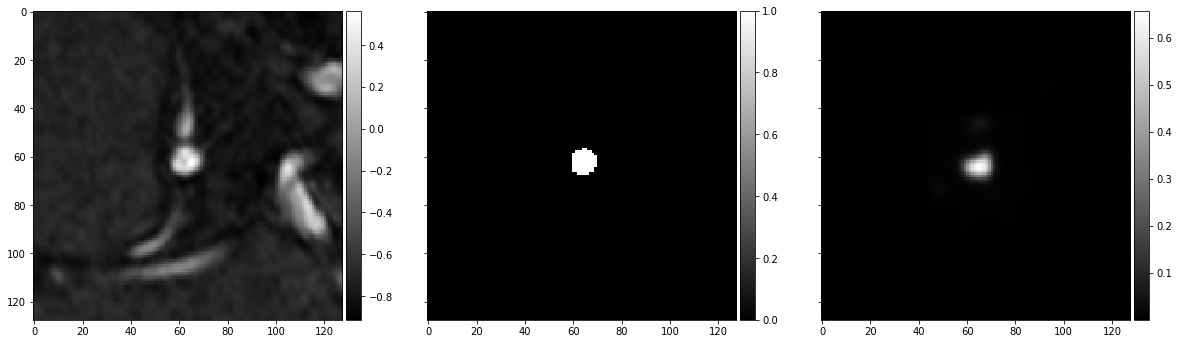

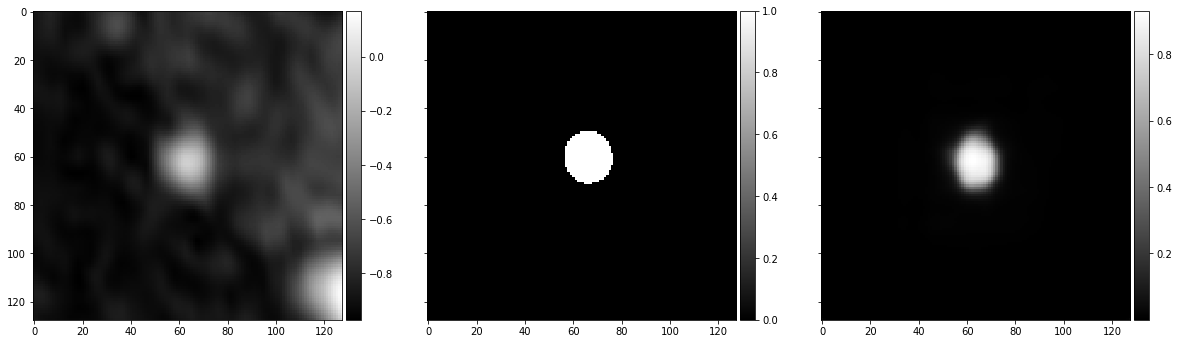

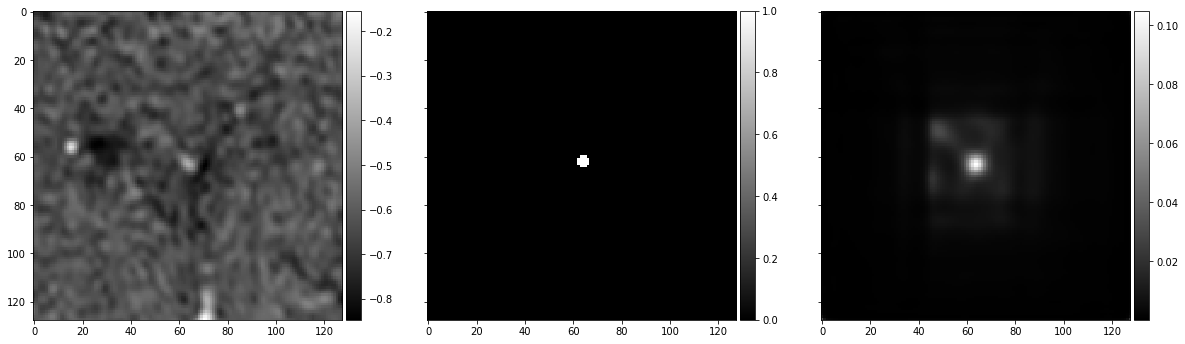

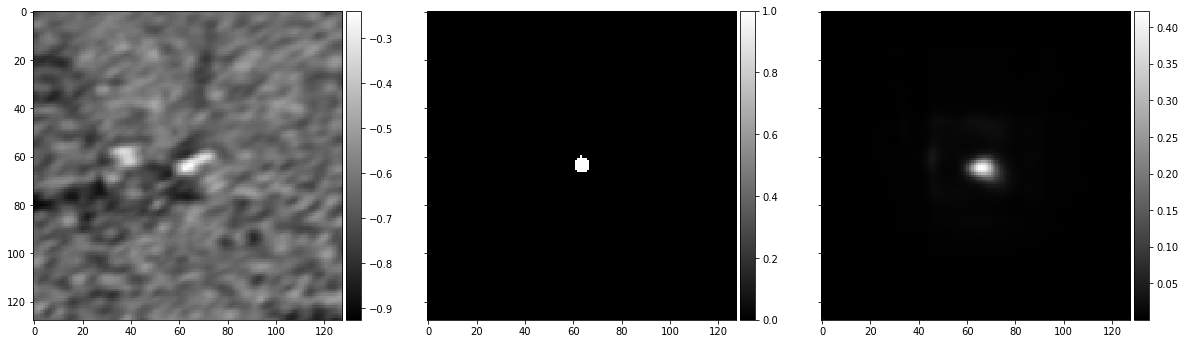

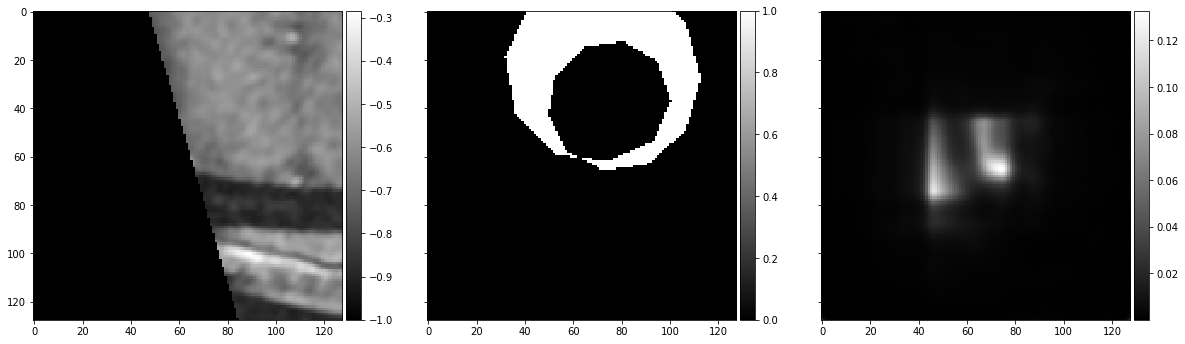

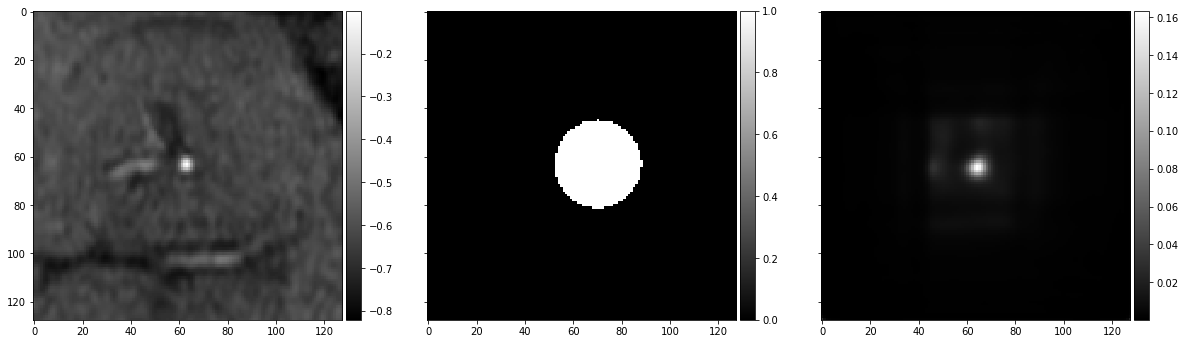

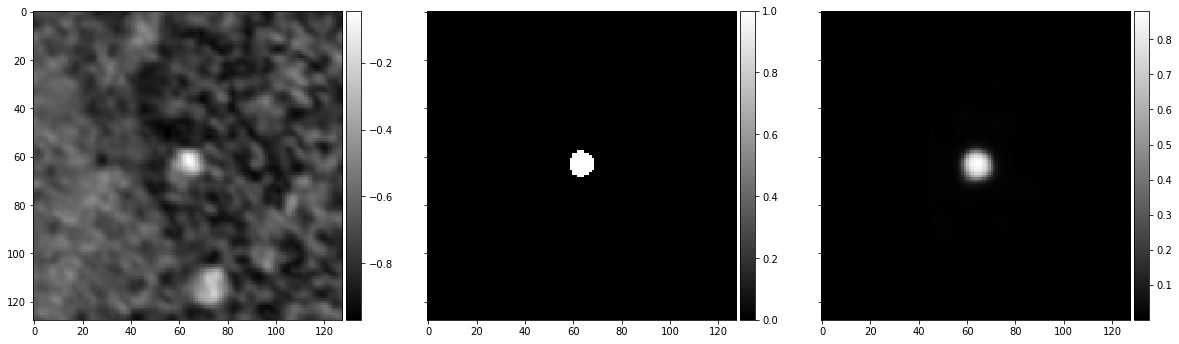

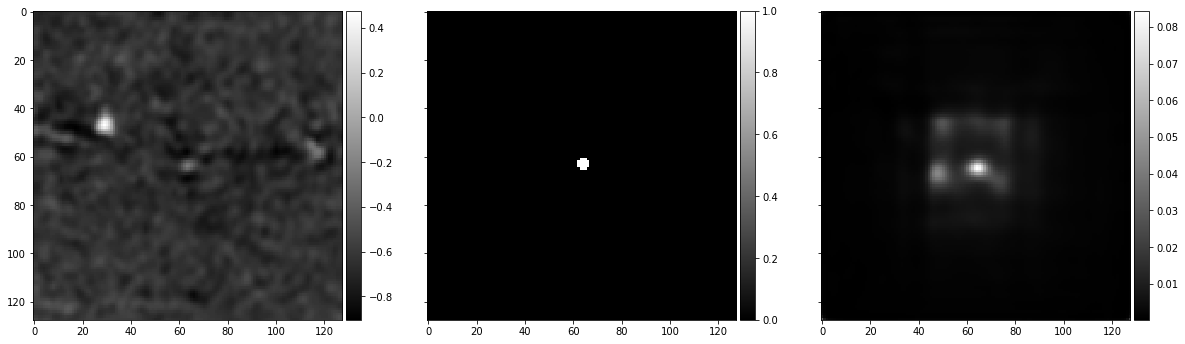

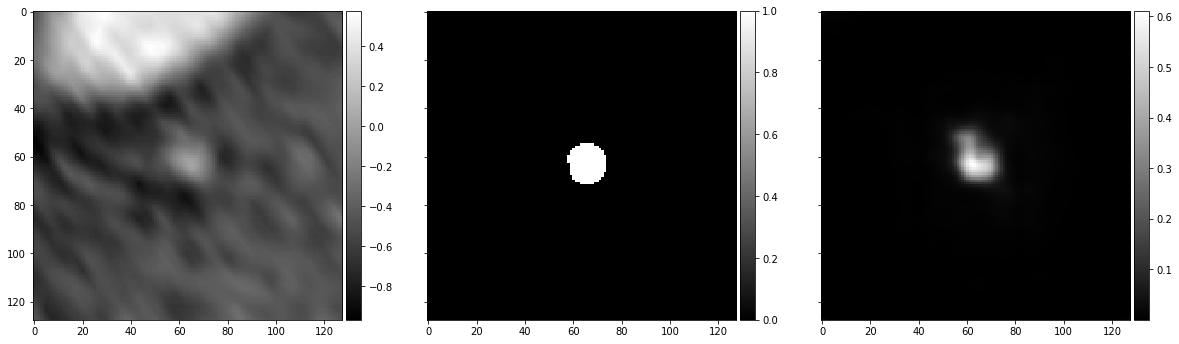

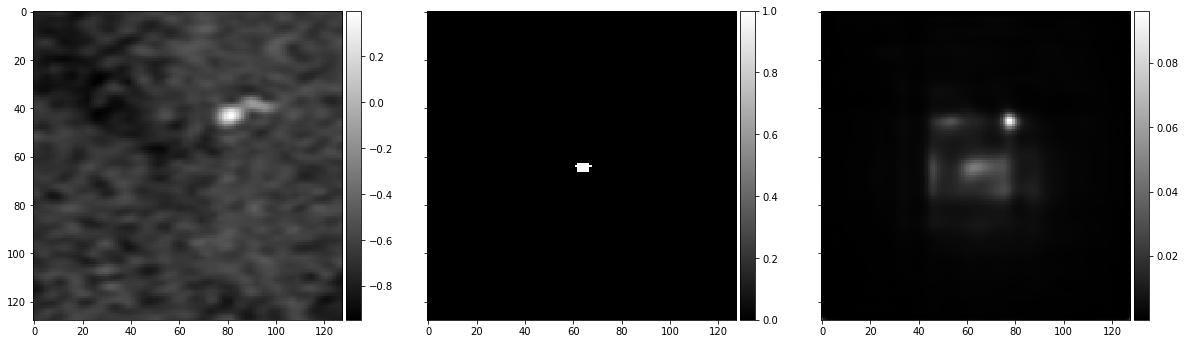

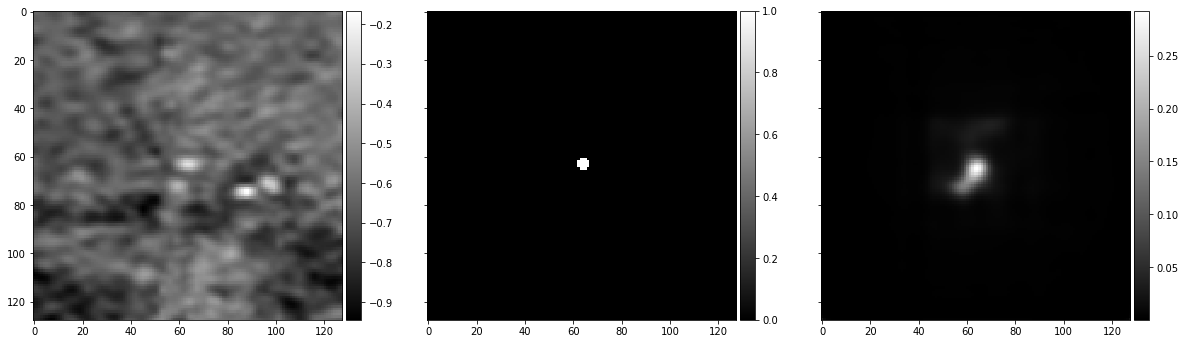

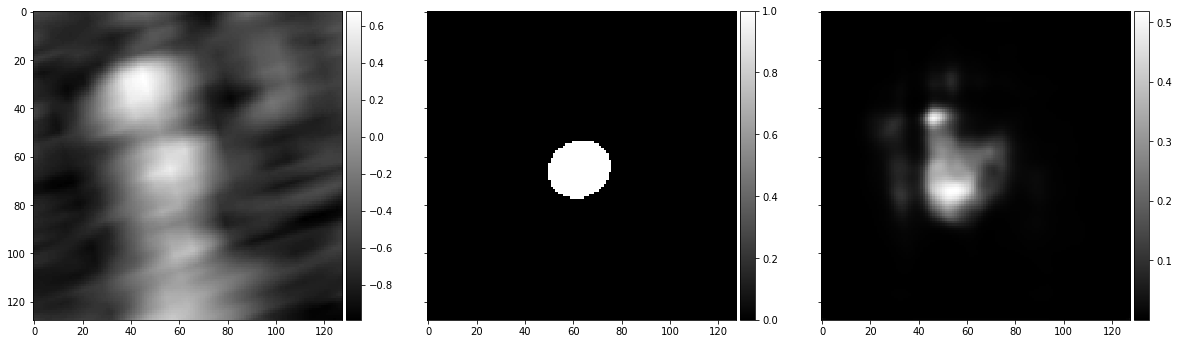

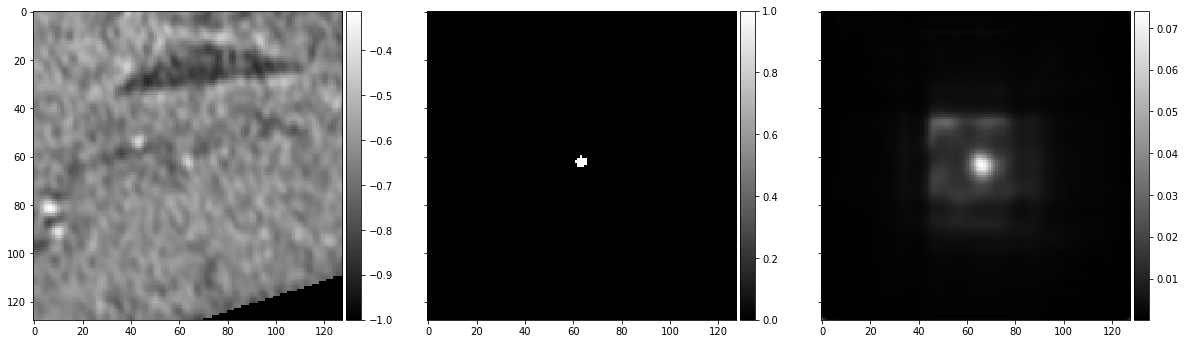

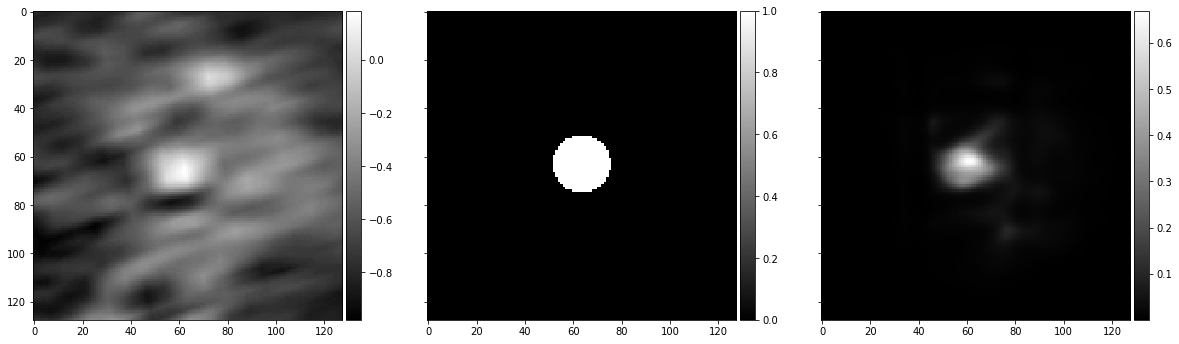

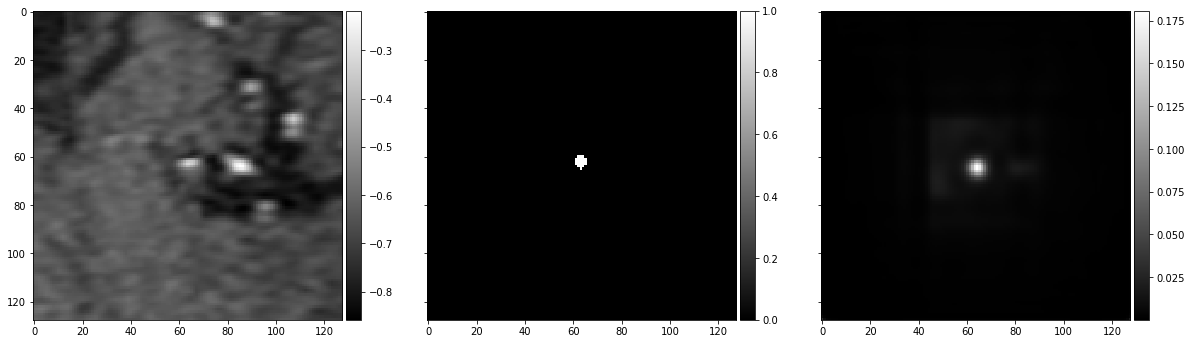

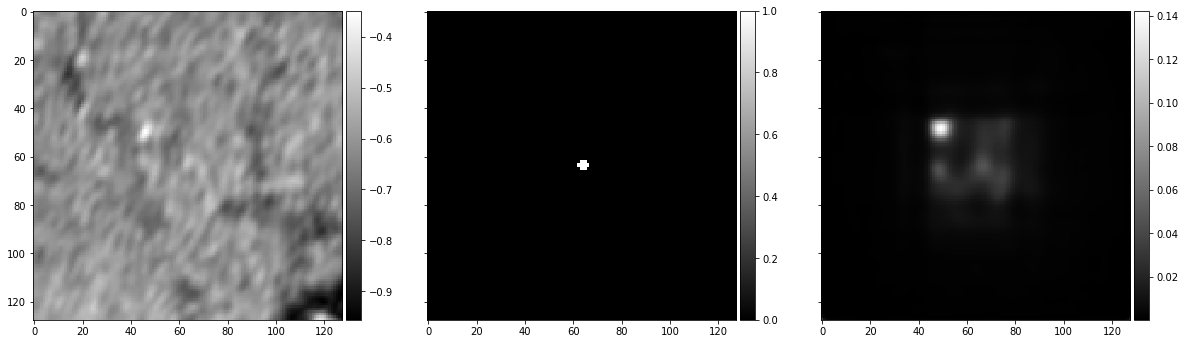

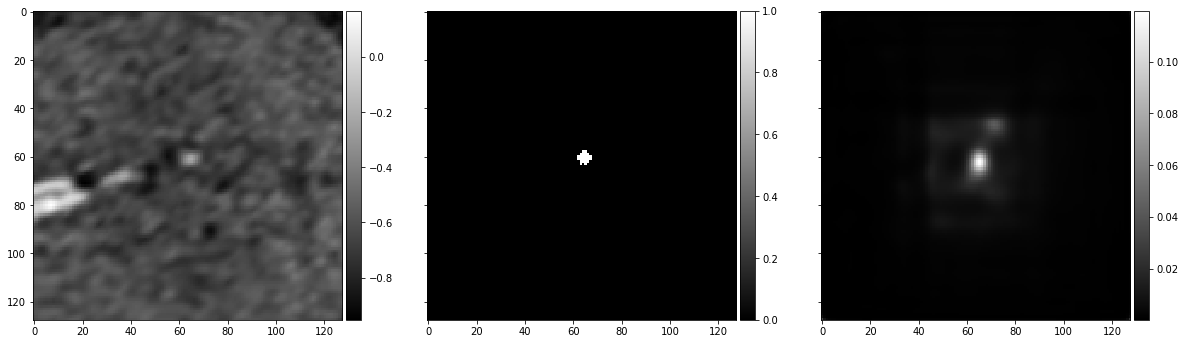

In [8]:
N=f_test.root.X.shape[0]
n=Nbatch 
for j in range(20):
    i = np.random.randint(N)
    xb = util.crop_center_nd(f_test.root.X[i:i+n], 
                                crop_dims,crop_dims)
    yb = util.crop_center_nd(f_test.root.Y[i:i+n],
                                crop_dims, crop_dims)
    ypred = sess.run(yclass,{x:xb,y:yb})
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    implot(xb[0,:,:,0],ax1)
    implot(yb[0,:,:,0],ax2)
    implot(ypred[0,:,:,0],ax3)
    plt.tight_layout
    plt.show()

In [9]:
N=f_test.root.X.shape[0]
print N
ypred=np.zeros((N,crop_dims,crop_dims,1)).astype(float)
ytrue=np.zeros((N,crop_dims,crop_dims,1)).astype(float)

for i in range(0,N,Nbatch):
    if i%1000 == 0:
        print i
    xb = util.crop_center_nd(f_test.root.X[i:i+Nbatch], 
                                crop_dims,crop_dims)
    yb = util.crop_center_nd(f_test.root.Y[i:i+Nbatch],
                                crop_dims, crop_dims)
    a = Nbatch
    if xb.shape[0] < Nbatch:
        a = xb.shape[0]
        print a
        tempx = np.zeros((Nbatch,crop_dims,crop_dims,1))
        tempy = np.zeros((Nbatch,crop_dims,crop_dims,1))
        
        tempx[:xb.shape[0]] = xb.copy()
        tempy[:xb.shape[0]] = yb.copy()
        
        xb = tempx.copy()
        yb = tempy.copy()
    yout =sess.run(yclass,{x:xb,y:yb})
    
    if a < Nbatch:
        ypred[i:i+Nbatch] = yout[:a].copy()
        ytrue[i:i+Nbatch] = yb[:a].copy()

    else:
        ypred[i:i+Nbatch] = yout.copy()
        ytrue[i:i+Nbatch] = yb.copy()

np.save('i2i_vanilla_segs_{}.npy'.format(MODEL_CODE),ypred)


16442
0
4000
8000
12000
16000
26


In [10]:
conts = []
from scipy.ndimage.morphology import binary_fill_holes, binary_erosion
for i in range(N):
    if i %1000==0:
        print i
    seg = ypred[i,:,:,0]
    seg = util.threshold(seg,0.2)
    seg = binary_fill_holes(seg)
    cont = util.marchingSquares(seg.astype(np.float32),iso=0.5,mode='center')
    conts.append(cont.copy())
    

np.save('i2i_vanilla_conts_{}.npy'.format(MODEL_CODE),conts)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [26]:
# saver = tf.train.Saver()
# saver.save(sess,'./models/i2i/i2i')

'./models/i2i/i2i'

In [6]:
saver = tf.train.Saver()
saver.restore(sess,'./models/i2i_vanilla_{}/i2i_{}'.format(MODEL_CODE,MODEL_CODE))

INFO:tensorflow:Restoring parameters from ./models/i2i_vanilla_mr/i2i_mr


In [7]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]
# mhas = [i.split('/')[-1] for i in mhas]
# mhas = ['./data/'+i for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

groups = open('groups.txt').readlines()
groups = [i.replace('\n','') for i in groups]

mr_test = open('mr_test.txt').readlines()
mr_test = [i.replace('\n','') for i in mr_test]

test_images = []
for i in range(len(mhas)):
    if any([c in mhas[i] for c in mr_test]):
        test_images.append((mhas[i],truths[i],paths[i],groups[i]))
        
print test_images

[('/home/marsdenlab/datasets/vascular_data/OSMSC0006/OSMSC0006-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0080/OSMSC0080-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0080/0080_0001/0080_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0080/0080_0001/0080_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0080/0080_0001/0080_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0082/OSMSC0082-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0082/0082_0001/0082_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0082/0082_0001/0082_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0082/0082_0001/0082_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0

In [8]:
from scipy.ndimage.morphology import binary_fill_holes, binary_erosion
def batch_seg(X,crop_dims):
    nbatch=Nbatch
    N=X.shape[0]
    ypred=np.zeros((N,crop_dims,crop_dims,1)).astype(float)

    for i in range(0,N,Nbatch):
        a = Nbatch
        xb = X[i:i+Nbatch]
        
        if xb.shape[0] < Nbatch:
            a = xb.shape[0]
            tempx = np.zeros((Nbatch,crop_dims,crop_dims,1))

            tempx[:xb.shape[0]] = xb.copy()

            xb = tempx.copy()
            
        yout =sess.run(yclass,{x:xb}).astype(float)

        if a < Nbatch:
            ypred[i:i+Nbatch] = yout[:a]

        else:
            ypred[i:i+Nbatch] = yout
        
    ypred = util.threshold(ypred,0.1)
    L = ypred.shape[0]
    for i in range(L):
        ypred[i,:,:,0] = np.flipud(ypred[i,:,:,0])
        ypred[i,:,:,0] = binary_fill_holes(ypred[i,:,:,0])
    return ypred.copy()

def reorder_contour(c):
    N = len(c)
    even_inds = np.arange(0,N,2)
    odd_inds = np.arange(1,N,2)
    
    even_points = np.asarray([c[i] for i in even_inds])
    odd_points = np.asarray([c[i] for i in odd_inds])
    
    N_even = len(even_points)
    ret = np.zeros_like(c)
    ret[:N_even] = even_points
    ret[N_even:] = np.flipud(odd_points)
    ret = ret[:-2]
    return ret.copy()

def ct_norm(x,im):
    return (1.0*x+1000)/(2000)

def mr_norm(x,im):
    #x = np.log(1.0*x-np.amin(x)+1)
#     m = np.amin(x,axis=(1,2,3), keepdims=True)
#     max_ = np.amax(x,axis=(1,2,3), keepdims=True)
    m = np.amin(x)
    max_ = np.amax(x)
    x = 2.0*(1.0*x-m)/(max_-m)-1.0    
    return x

In [9]:
import vtk
import os

util.mkdir('pred_groups')

In [10]:

ext = [127, 127]
DIMS = [128,128]
ISOVALUE=0.5
NUM_MODES = 5


In [11]:
util.gen_groups(test_images,batch_seg,mr_norm,ext,DIMS,ISOVALUE,NUM_MODES,
                crop_dims,'i2i','./pred_groups')

/home/marsdenlab/datasets/vascular_data/OSMSC0006/OSMSC0006-cm.mha
(0.025, 0.025, 0.025)
right_iliac
celiac_branch
left_internal_iliac
celiac_trunk
renal_right
right_internal_iliac
renal_left
aorta
superior_mesentaric
/home/marsdenlab/datasets/vascular_data/OSMSC0080/OSMSC0080-cm.mha
(0.025, 0.025, 0.025)
LPA_23
LPA_24
LPA_25
LPA_26
LPA_19
LPA_20
LPA_21
LPA_22
LPA_27
LPA_28
LPA
LPA_3
LPA_7
RPA_21
RPA_20
RPA_17
RPA_16
RPA_19
RPA_18
RPA_13
RPA_12
RPA_15
RPA_14
LPA_41
LPA_42
RPA_44
RPA_45
RPA_42
RPA_43
LPA_39
LPA_40
RPA_46
LPA_38
LPA_2
LPA_6
RPA_1
LPA_37
LPA_32
LPA_31
LPA_30
LPA_29
LPA_36
LPA_35
LPA_34
LPA_33
RPA_22
RPA_23
RPA_24
RPA_25
RPA_26
RPA_27
RPA_28
RPA_29
RPA_30
RPA_31
LPA_1
LPA_5
LPA_44
LPA_43
LPA_46
LPA_45
LPA_10
LPA_9
LPA_12
LPA_11
LPA_14
LPA_13
LPA_16
LPA_15
LPA_18
LPA_17
RPA_10
RPA_11
RPA_8
RPA_9
RPA_6
RPA_7
RPA_4
RPA_5
RPA_2
RPA_3
RPA
LPA_4
LPA_8
RPA_39
RPA_38
RPA_37
RPA_36
RPA_35
RPA_34
RPA_33
RPA_32
RPA_41
RPA_40
/home/marsdenlab/datasets/vascular_data/OSMSC0082/OSMSC0082